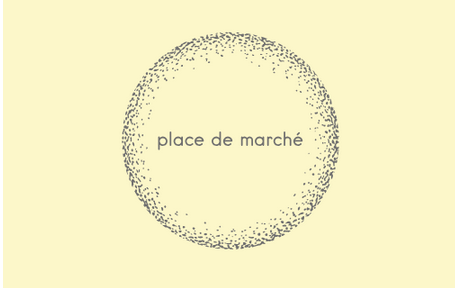

# <a name = "sommaire"> Sommaire 
- <a href ="#import"> Importation des bibliothèques et des données </a>
- <a href ="#fonction"> Fonctions de visualisation et prétraitement </a>
- <a href ="#nett"> Prétraitement:  </a>
    - <a href ="#nett_col2"> Prétraitement du nom du produit </a>
    - <a href ="#nett_col3"> Nombres de cluster </a>
- <a href ="#Extract"> Extraction des features de texte:
  - <a href ="#bow"> Bag of words
    - <a href ="#bow1"> CountVectorizer
    - <a href ="#bow1"> TF-IDF
  - <a href ="#WE"> Word embedding
    - <a href ="#WE1"> Word2Vec
  - <a href ="#SE"> Sentence embedding
    - <a href ="#SE1"> BERT
    - <a href ="#SE2"> USE
- <a href ="#Conclusion"> Conclusion

Le but ici est de faire tous les prétaitements et méthodes utilisés sur la partie texte du 1er notebook avec seulement le nom du produit.

# <a name = "import"> Importation des bibliothèques et des données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
!pip install word2number &> /dev/null 
!pip install unidecode &> /dev/null 
!pip install contractions &> /dev/null 
!pip install -q -U "tensorflow-text==2.8.*" &> /dev/null 
!pip install scikit-learn-intelex &> /dev/null
#!pip install umap-learn &> /dev/null

In [ ]:
#from sklearnex import patch_sklearn
#import sklearnex
#patch_sklearn('KMeans')
#sklearnex.unpatch_sklearn()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import unidecode
import contractions
from word2number import w2n

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model

import gensim
from gensim.models import Word2Vec

from skimage import color, exposure
from skimage.filters import gaussian
from skimage import img_as_ubyte
from skimage.transform import rescale
import cv2

import warnings
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/P6 classification/data/flipkart_com-ecommerce_sample_1050.csv')

# <a name = "fonctions"> Fonctions de visualisation et de prétraitement</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def text_preprocessing(text: str, number = True, final_join = True) -> str:
  """Prétraitement d'un texte en supprimant les stop words, les ponctuations, les raccourcis d'un mot et traiter la base d'un mot avec la lemmatisation
  Args:
      text (str): Texte à nettoyer
      number (bool, optionnel): Permet de supprimer les nombres du texte. Initialiser par True par défaut
      final_join (bool, optionnel): Initialisé a False le prepocessing renvoie une liste de mot par phrase. Initialisé a True par défaut
  Returns:
      str:  Retourne le texte prétaité sous forme de chaine de caractère si final_join est True sinon une liste de mots"""
  
  words = pd.read_json('/content/drive/MyDrive/P6 classification/data/stop_words_english.json')
  wdr = list(words[0])

  stop_words_nltk = stopwords.words('english')

  stop_words_en = list(set(wdr+stop_words_nltk))
  wd = WordNetLemmatizer()
  # Text en minuscule
  sentence = text.lower()

  # Enleve tout accent
  text = unidecode.unidecode(sentence)

  # Redefinir les mots raccourcis exemple : we're -> we are
  text1 = contractions.fix(text)

  # Création des tokens
  text_token = word_tokenize(text1)

  # Enlever les ponctuations
  text_no_punct = [''.join(c for c in s if c not in string.punctuation) for s in text_token]

  # Suppression des stopwords
  text_no_stop_words = [i for i in text_no_punct if i not in stop_words_en]

  # Suppression des nombres
  # Suppression des nombres
  if number:
    new_text =  [item for item in text_no_stop_words if not item.isdigit()]
  else: new_text = text_no_stop_words

  # Suppression des espaces en trop 
  new_text1 = [item for item in new_text if item != '']

  # Lemmatizer (base d'un mot)
  #final_text = [wd.lemmatize(i) if len(i) > 2 else i for i in new_text1] 
  final_text = [wd.lemmatize(i) for i in new_text1] 

  # Garder seulement les mots avec une longueur de 2
  #final = [word for word in final_text if len(word) > 2]

  # Text final retourner
  if final_join:
    return ' '.join(final_text)
  else: return final_text




def simple_bag_of_words(feature_extraction, dataframe: pd.DataFrame, column = 'description_new', features_names=False):
  """Crée une matrice de fréquence de mots à partir d'une colonne texte
     Args:
         feature_extraction: modèle de feature extraction type CountVectorizer ou Tf–idf
         dataframe (pd.Dataframe): Dataframe sur lequel effectuer le feature extraction
         column (str, optionnel): Noms de la colonne
         features_names (bool, optionnel): Renvoi le nom des features extraites
     Returns:
        list, np.array: Retourne le nom des features extraites en plus de la matrice de fréquence d'un mot
  """
  vectorizer = feature_extraction
  X = vectorizer.fit_transform(dataframe[column])
  if features_names:
    names = vectorizer.get_feature_names_out()
  else: names = []
  return X, names


def visualizer(df: pd.DataFrame, clf):
  """Permet de visualiser les différents clusters en 2 dimensions avec TSNE et visualiser la silhouette score
     Args:
        df (pd.DataFrame): Caractéristique d'entrée
        clf: Modèle de clustering qui dispose de n_clusters comme paramètre
  """
  fig, axs = plt.subplots(1, 2, figsize = (20, 12))
  visualizer = InterclusterDistance(clf, embedding = 'tsne', ax = axs[0])
  visualizer.fit(df)
  visualizer.finalize() 

  visualizer = SilhouetteVisualizer(clf, colors='yellowbrick', ax = axs[1])
  visualizer.fit(df)
  visualizer.finalize() 



def reduc_tsne(data: pd.DataFrame):
  """Permet de faire une réduction à 2 dimension avec TSNE
     Args:
         data (pd.DataFrame): Dataframe sur lequel faire la reduction de dimension
     Returns:
         np.array: Retourne les deux premières composantes de TSNE"""
  tsne = TSNE(n_components = 2, learning_rate='auto', init = 'random', perplexity = 30, random_state = 0)
  return tsne.fit_transform(data)

def categories(x:str)-> str:
  """Retourne la première chaine de caractères contenu dans x, en enlevant les crochets et le sépareteur ">>"
  Args:
    x (str): Chaine de caractère à traiter
  Returns:
    str: Retourne la première chaine de caractères contenu dans x, en enlevant les crochets et le sépareteur ">>" """

  line = x.replace('["', '').replace('"]', '')
  line_s = line.split('>>')
  line_strip = [i.strip() for i in line_s]
  return line_strip[0]




def sentence_2_vec(sentence:str, model):
  """Convertit une phrase en un vecteur en utilisant un modèle de représentation de mots
  Args:
    sentence (str): Texte à convertir en vecteur
    model: Modèle de représentation de mots
  Returns: 
    np.array: Vecteur de représentation de la phrase
  """
  # vecteur pour chaque token
  model_vectors = model.wv

  # dimension de représentation
  p = model.vector_size

  # init vecteur
  vec = np.zeros(p)

  # nb tokens trouvés 
  nb = 0

  # Traiter chaque token de chaque phrase
  for tk in sentence:

    # Traiter seulement les tokens reconnus
    try:
      val = model_vectors[tk]
      vec += val
      nb += 1
    except: 
      pass
  # moyenne des valeurs uniquement si on trouve des tokens reconnus
  if nb > 0:
    vec = vec / nb
  
  return vec


def int_labels(x, l):
  """Renvoie l'indice d'un élément dans une liste
  Args:
      x (str): Élément à rechercher dans la liste
      l (list): Liste dans laquelle rechercher l'élément
  Returns:
      int: Indice de l'élément dans la liste. -1 si l'élément n'est pas trouvé"""

  for key, lab in enumerate(l):
    if lab in x:
      return key
  return -1
  

def build_histogram(kmeans, des, image_num):
  
  """
    Construit un histogramme de visual words d'une image donnée en utilisant le modèle de kmeans
    
    Args:
        kmeans:  Modèle KMeans déjà entrainé
        des (np.array): Un tableau de descripteurs à classer
        image_num (int): Numéro de l'image associée aux descripteurs
        
    Returns:
        np.array: Un vecteur de taille len(kmeans.cluster_centers_) avec une pondération
    """
  # prédiction de chaque descripteur
  res = kmeans.predict(des)

  # histogramme de taille k
  histo = np.zeros(len(kmeans.cluster_centers_))

  # nombre de descripteur
  nb_des = len(des)

  if nb_des == 0 : 
    print("problème histogramme image  : ", image_num)

  # création de l'histogramme avec une pondération
  for i in res:
    histo[i] += 1 / nb_des
  return histo


def kmeans_result(embedded, dataframe, name_col):
  """Entraine un KMeans et ajoute les labels dans un dataframe
  
  Args:
    embedded: Tableau numpy avec les données sur lesquelles appliquer le Kmeans
    dataframe: dataframe auquel ajouter les résultats
    name_col: nom de la colonne dans le dataframe ou seront ajoutées les labels

  Returns: 
    pd.DataFrame: Retourne le dataframe avec une colonne supplémentaire contenant les différents labels"""
  model = KMeans(7, random_state=0).fit(embedded)
  kmeans_df = dataframe.copy()
  kmeans_df[name_col] = model.labels_
  return  kmeans_df
  
def transform_conf_mat(y_pred, list_corresp):
  df_labels = pd.Series(y_pred).to_frame('y_pred')

  return df_labels.y_pred.apply(lambda x: np.array(list_corresp[x]))



def vis_true_pred(embedded, dataframe, y_true, y_pred):
  """
  Affiche deux nuage de points à deux dimensions obtenues grâce à une réduction de dimension.
  Les couleurs des points sont basées sur la valeur de y_true pour le premier nuage de points et y_pred pour le second nuage de points
  Agrs:
    embedded: tableau de données de dimension (n, 2) contenant les projections des données
    dataframe: dataframe contenant les données y_true et y_pred
    y_true: nom de la colonne du DataFrame
    y_pred: nom de la colonne de DataFrame
  """
  fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (17, 10))
  sns.scatterplot(x = embedded[:,0], y = embedded[:,1], hue = dataframe[y_true], ax = axs[0])
  sns.scatterplot(x = embedded[:,0], y = embedded[:,1], hue = dataframe[y_pred], ax = axs[1])



def vis_conf_mat(trans_label, dataframe, y_true):
  """Visualisation d'une matrice de confusion
  Args:
    trans_labels: labels transformer
    dataframe: DataFrame initial avec les y_true
    y_true: Nom de la colonne dans le dataframe qui contient les vrais labels"""
  cm2 = confusion_matrix(dataframe[y_true], trans_label)
  df_conf = pd.DataFrame(cm2, columns=range(7), index=labels)
  plt.figure(figsize = (15, 10))
  sns.heatmap(df_conf, annot=True, cmap= 'Blues', fmt='g')
  plt.show()


def vis_class_rapport(dataframe, y_true, trans_labels):
  """ 
  Affiche une heatmap du rapport de classification 
  Args:
    dataframe: DataFrame initial avec les y_true
    y_true: Nom de la colonne dans le dataframe qui contient les vrais labels
    trans_labels: labels transformer
  """
  clf_report_kmeans = classification_report(dataframe[y_true],
                                    trans_labels,
                                    output_dict=True)
  plt.figure(figsize = (15, 10))
  df = pd.DataFrame(clf_report_kmeans).T.loc[:, :'f1-score'].iloc[:8].reset_index()
  df.loc[:6, 'index'] = labels
  df = df.set_index('index')
  sns.heatmap(df, annot=True, cmap= 'Blues', fmt='.2')
  plt.show()

# <a name = "desc"> Description du jeu de données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
# nombres de lignes et de colonnes
nb_row, nb_col = df.shape 

# Taux de remplissage moyen
fill_rate = str(round(df.notna().mean().mean() * 100, 2)) + '%'  

# Nombres de doublons 
dup_data = df.duplicated(['uniq_id']).sum()

columns_df_desc = ['Nombres de lignes', 'Nombres de colonnes', 'Taux de remplissage moyen', 'Nombres de doublons']

df_desciption = pd.DataFrame(columns = columns_df_desc)
df_desciption['Nombres de lignes'] = [nb_row]
df_desciption['Nombres de colonnes'] = [nb_col] 
df_desciption['Taux de remplissage moyen'] = [fill_rate]
df_desciption['Nombres de doublons'] = [dup_data]
df_desciption

,Nombres de lignes,Nombres de colonnes,Taux de remplissage moyen,Nombres de doublons
0,1050,15,97.83%,0


In [ ]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


# <a name = "nett"> Prétraitement</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "nett_col2"> Prétraitement du nom du produit</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
df['product_name_new'] = df['product_name'].apply(lambda x: text_preprocessing(x))

### <a name = "nett_col3"> Nombres de cluster </a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
# profondeurs pour chaque produits
nb_tree = df['product_category_tree'].apply(lambda x: x.count('>>'))
print(f'Max depth: {nb_tree.max()}')

Max depth: 6


In [ ]:
dict_cat = {}

for k, row in df.iterrows():
  line = row.product_category_tree
  line_r = line.replace('["', '').replace('"]', '')
  line_s = line_r.split('>>')
  line_strip = [i.strip() for i in line_s]
  for i in range(6):
    cat = 'category_lvl_' + str(i)
    if cat not in dict_cat:
      dict_cat[cat] = []
    try:
      dict_cat[cat].append(line_strip[i])
    except IndexError:
      dict_cat[cat].append(np.nan)

In [ ]:
df_categories_lvl = pd.DataFrame(dict_cat)
df_categories_lvl.head()

,category_lvl_0,category_lvl_1,category_lvl_2,category_lvl_3,category_lvl_4,category_lvl_5
0,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,NaN,NaN
1,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",NaN
2,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,NaN
3,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,NaN
4,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,NaN


In [ ]:
# Mettre chaque niveau de catégorie dans un dataframe
cat_0 = df_categories_lvl.category_lvl_0.value_counts(normalize = True).to_frame('count').reset_index()
cat_1 = df_categories_lvl.category_lvl_1.value_counts(normalize = True).to_frame('count').reset_index()
cat_2 = df_categories_lvl.category_lvl_2.value_counts(normalize = True).to_frame('count').reset_index()
cat_3 = df_categories_lvl.category_lvl_3.value_counts(normalize = True).to_frame('count').reset_index()
cat_4 = df_categories_lvl.category_lvl_4.value_counts(normalize = True).to_frame('count').reset_index()
cat_5 = df_categories_lvl.category_lvl_5.value_counts(normalize = True).to_frame('count').reset_index()

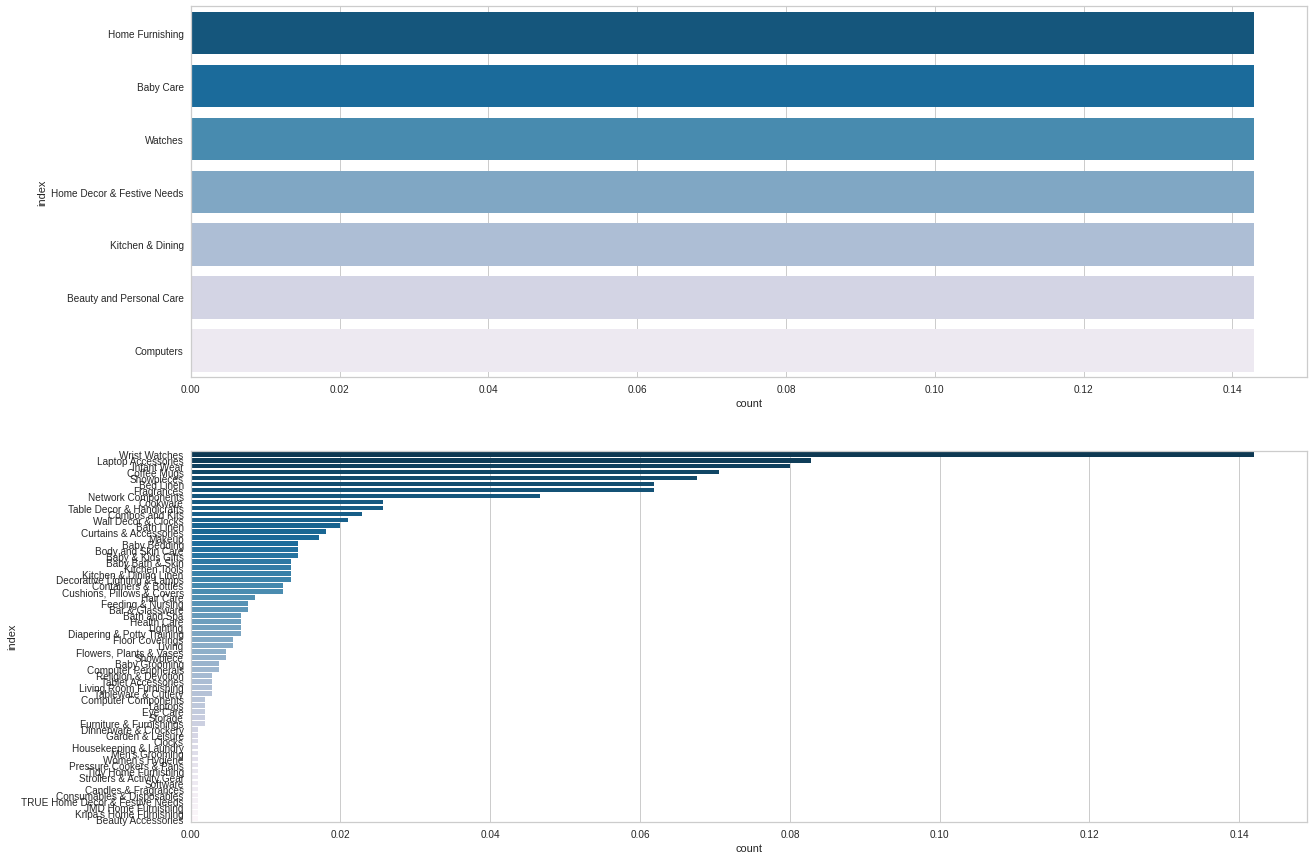

In [ ]:
# Visualisation des deux premiers niveau de catégories
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (20, 15))
sns.barplot(x = 'count', y = 'index', data = cat_0, ax = axs[0], palette = 'PuBu_r')
sns.barplot(x = 'count', y = 'index', data = cat_1, ax = axs[1], palette = 'PuBu_r')
plt.show()

In [ ]:
# Création d'une nouvelle variable avec la catégories principale
df['target'] = df['product_category_tree'].apply(lambda x: categories(x))

In [ ]:
# création des int labels
labels = list(df.target.unique())
df['target_int'] = df.target.apply(lambda x: int_labels(x, labels))

# <a name = "Extract"> Extraction des features de texte</a> <a href ="#sommaire"> Retour au sommaire</a>

## <a name = "bow">Bag of words</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "bow1">CountVectorizer</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
vec = CountVectorizer()
X, names = simple_bag_of_words(vec, df, features_names = True, column = 'product_name_new')
len(names)

2065

In [ ]:
# Réduction de dimension - TSNE
X_embedded = reduc_tsne(X)
# Résultats du kmeans
count_vec_result = kmeans_result(X_embedded, df, 'kmeans_count_vec_')

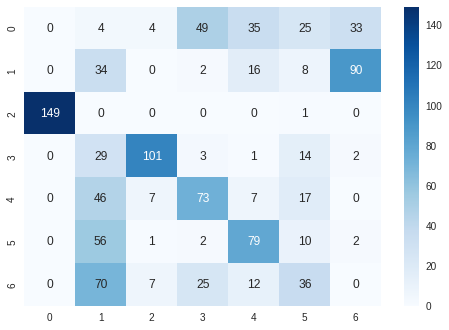

In [ ]:
# Visualisation de matrice de confusion
cm = confusion_matrix(count_vec_result.target_int, count_vec_result.kmeans_count_vec_)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

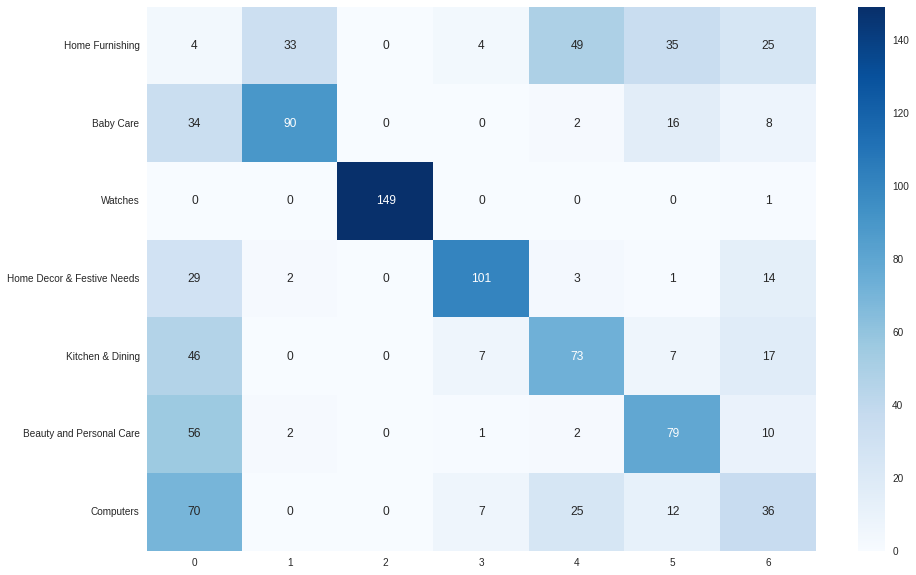

In [ ]:
# Reordonner les clusters
labels_trans = transform_conf_mat(count_vec_result.kmeans_count_vec_,[2, 0, 3, 4, 5, 6, 1])
vis_conf_mat(labels_trans, count_vec_result, 'target_int')

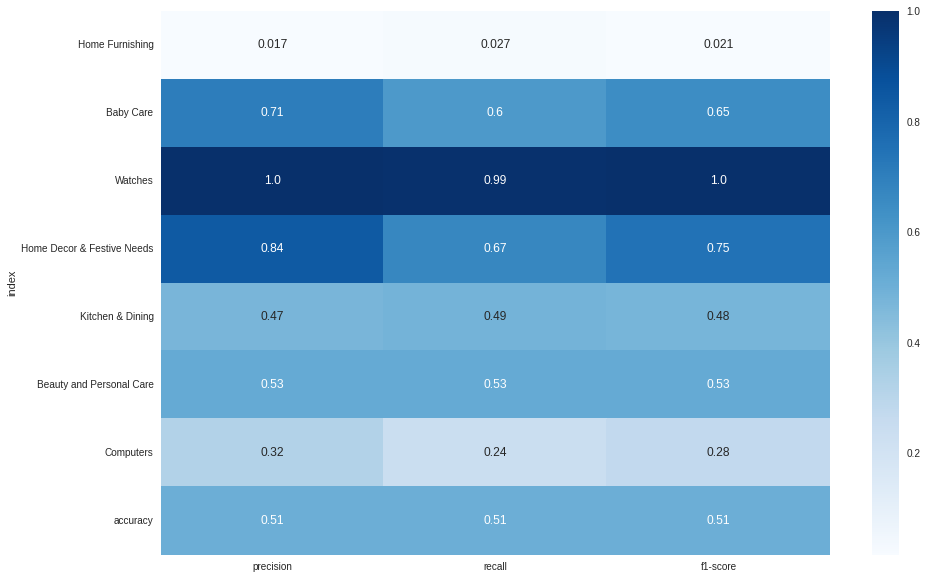

In [ ]:
vis_class_rapport(count_vec_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(count_vec_result.target_int, count_vec_result.kmeans_count_vec_)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.35


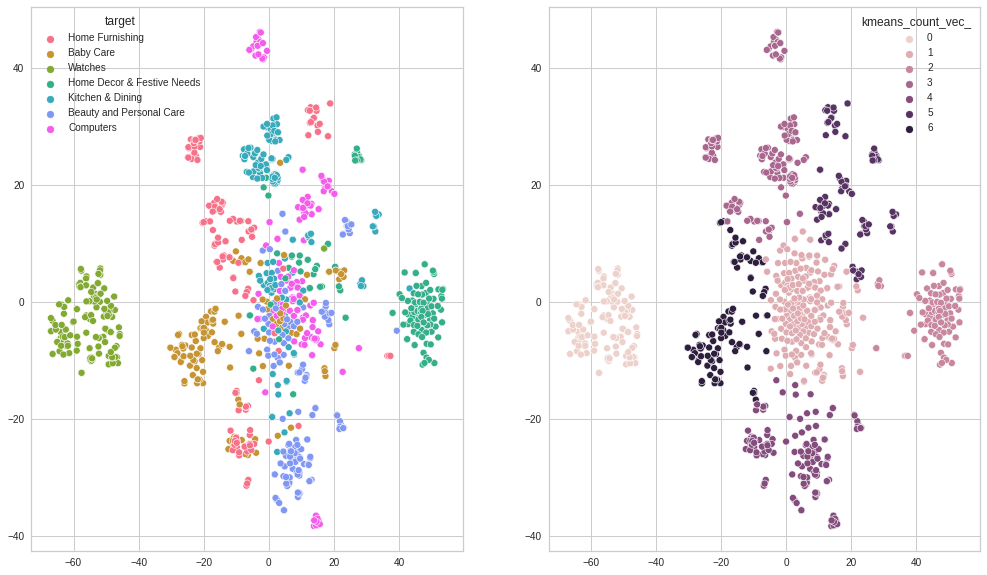

In [ ]:
vis_true_pred(X_embedded, count_vec_result, 'target', 'kmeans_count_vec_')

On se retrouve avec un résultat assez similaire qu'on a eu sur le 1er notebook. Ici on obtient le résultat le plus faible du fait qu'on traite le nom du produit seul et donc moins de mot à notre disposition.

### <a name = "bow2">TF-ID</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
# Initialisation du modèle
vec_tf = TfidfVectorizer()
X, names = simple_bag_of_words(vec_tf, df, features_names = True, column = 'product_name_new')

In [ ]:
# Réduction de dimension avec TSNE
X_embedded_tf_idf = reduc_tsne(X)
tf_idf_result = kmeans_result(X_embedded_tf_idf, df, 'kmeans_tf_idf_')

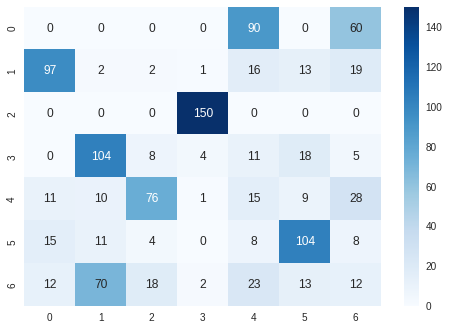

In [ ]:
# Visualisation de matrice de confusion
cm = confusion_matrix(tf_idf_result.target_int, tf_idf_result.kmeans_tf_idf_)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

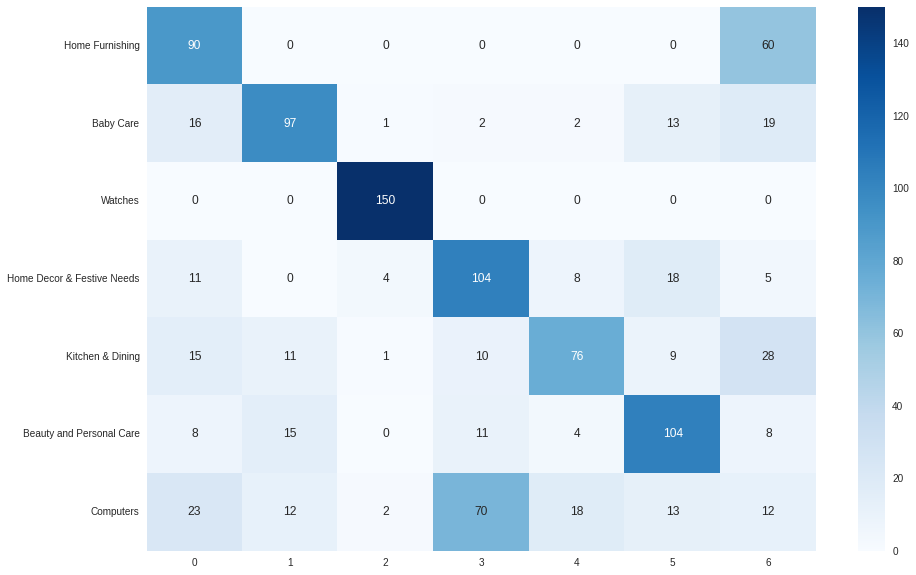

In [ ]:
#Réordonner les labels
labels_trans = transform_conf_mat(tf_idf_result.kmeans_tf_idf_,[1, 3, 4, 2, 0, 5, 6])
vis_conf_mat(labels_trans, tf_idf_result, 'target_int')

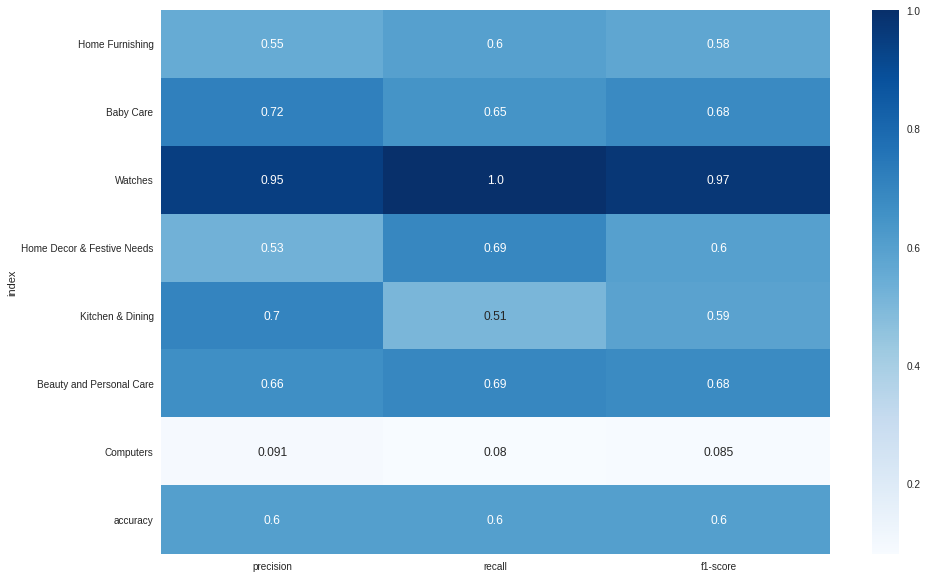

In [ ]:
vis_class_rapport(tf_idf_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(tf_idf_result.target_int, tf_idf_result.kmeans_tf_idf_)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.42


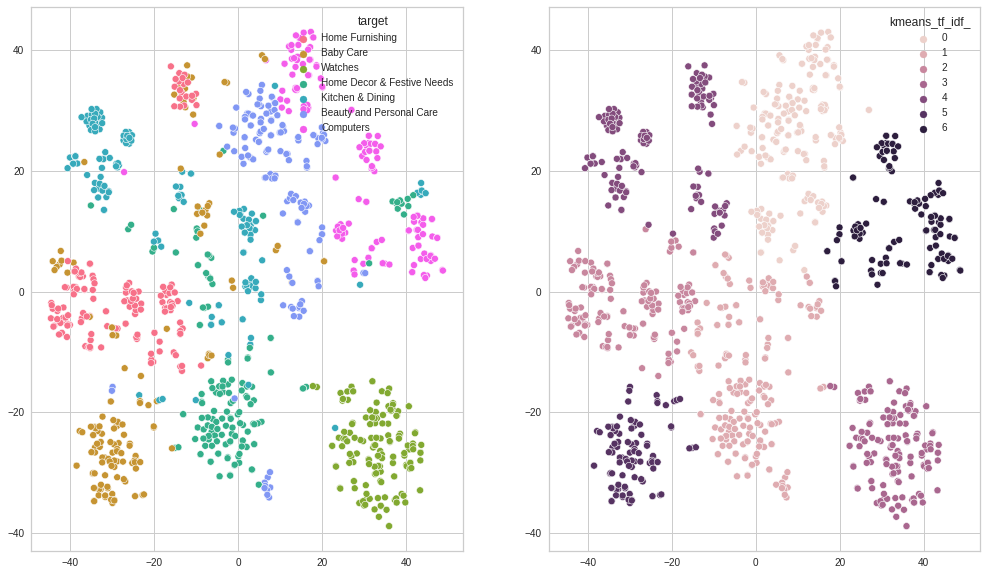

In [ ]:
vis_true_pred(X_embedded_tf_idf, tf_idf_result, 'target', 'kmeans_tf_idf_')

Ici aussi on obtient des résultats assez similaires qu'on a eu aussi sur le 1er notebook. Ici aussi, on obtient un résultat plus faible du fait qu'on traite le nom du produit seul et donc moins de mot à notre disposition.

## <a name = "WE">Word embedding</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "WE1">Word2Vec</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
text = df['product_name_new'].apply(lambda x: text_preprocessing(x, final_join = False))
text[:5]

0    [elegance, polyester, multicolor, abstract, ey...
1                      [sathiyas, cotton, bath, towel]
2           [eurospa, cotton, terry, face, towel, set]
3    [santosh, royal, fashion, cotton, printed, kin...
4    [jaipur, print, cotton, floral, king, sized, d...
Name: product_name_new, dtype: object

In [ ]:
model = gensim.models.Word2Vec(window = 5, seed  = 0 , size = 300)
model.build_vocab(text)
model.train(text, total_examples = model.corpus_count, epochs = 100)

# traitement de chaque description 
sentences_vec = []

for doc in text:
  vec = sentence_2_vec(doc, model)

  sentences_vec.append(vec)

In [ ]:
mat_vec = np.array(sentences_vec)
mat_vec

array([[ 0.38565736, -0.1744342 , -0.59481858, ...,  0.40215621,
         0.12648277, -0.27242137],
       [ 0.09323516,  0.35111274, -0.28935816, ..., -0.11158844,
         0.1583786 ,  0.10623435],
       [ 0.08076376,  0.3127124 , -0.23410424, ..., -0.1436097 ,
         0.05976145,  0.14431333],
       ...,
       [-0.00949231,  0.16181532, -0.09150538, ..., -0.05898828,
        -0.01806537, -0.3060784 ],
       [-0.00155052,  0.21270615, -0.11181799, ..., -0.02327367,
        -0.00758196, -0.31900891],
       [-0.00486554,  0.1863243 , -0.0866883 , ..., -0.05511476,
        -0.02956   , -0.29331904]])

In [ ]:
mat_vec.shape

(1050, 300)

In [ ]:
# transformation en dataframe
df_vec = pd.DataFrame(mat_vec, columns = ['v' + str(i+1) for i in range(mat_vec.shape[1])])
df_vec.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v291,v292,v293,v294,v295,v296,v297,v298,v299,v300
0,0.385657,-0.174434,-0.594819,0.271956,0.135955,0.640881,0.164704,0.175674,-0.019160,-0.175807,...,0.024556,-0.241812,-0.155114,-0.316273,-0.038376,0.163307,0.204159,0.402156,0.126483,-0.272421
1,0.093235,0.351113,-0.289358,-0.135523,0.079334,0.483706,0.100972,0.070943,-0.169097,-0.023493,...,-0.048297,-0.400433,-0.080465,-0.096493,0.429141,0.213528,0.121810,-0.111588,0.158379,0.106234
2,0.080764,0.312712,-0.234104,-0.151161,0.057828,0.410470,0.121791,0.052009,-0.186541,0.122263,...,-0.043188,-0.256717,-0.015941,-0.047956,0.330031,0.192393,0.114492,-0.143610,0.059761,0.144313
3,0.251489,0.089328,-0.274768,-0.010532,0.053775,0.395138,0.078247,0.047209,-0.135156,-0.071242,...,0.102842,-0.335214,-0.086144,-0.101812,0.222155,0.075279,0.142930,0.103456,0.097702,-0.041246
4,0.201164,0.170094,-0.303903,-0.053174,0.074496,0.458574,0.084802,0.045967,-0.192553,-0.047874,...,0.133044,-0.305929,-0.028515,-0.158120,0.280856,-0.000016,0.177216,0.081371,0.172227,-0.012591


In [ ]:
# TSNE
X_embedded_w2v = reduc_tsne(df_vec)
# Résultat Kmeans
w2v_result = kmeans_result(X_embedded_w2v, df, 'kmeans_w2v')

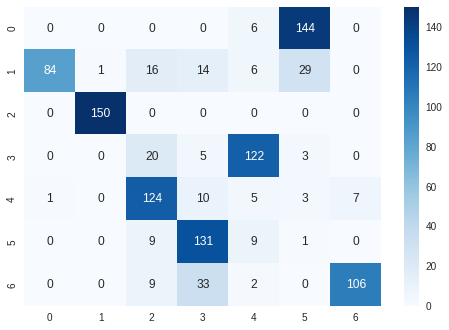

In [ ]:
# Visualisation de la matrice de confusion
cm = confusion_matrix(w2v_result.target_int, w2v_result.kmeans_w2v)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

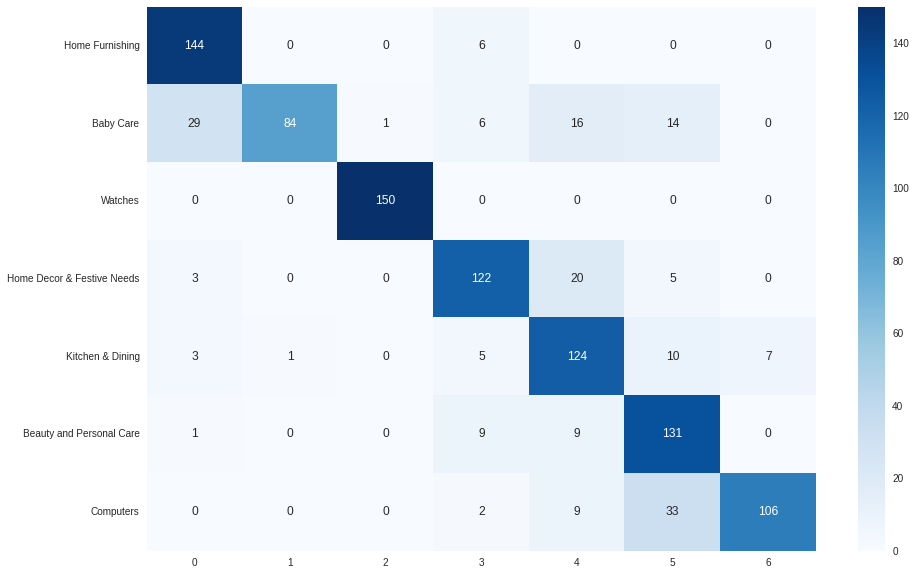

In [ ]:
# Réordonnée les labels
labels_trans = transform_conf_mat(w2v_result.kmeans_w2v,[1, 2, 4, 5, 3, 0, 6])
vis_conf_mat(labels_trans, w2v_result, 'target_int')

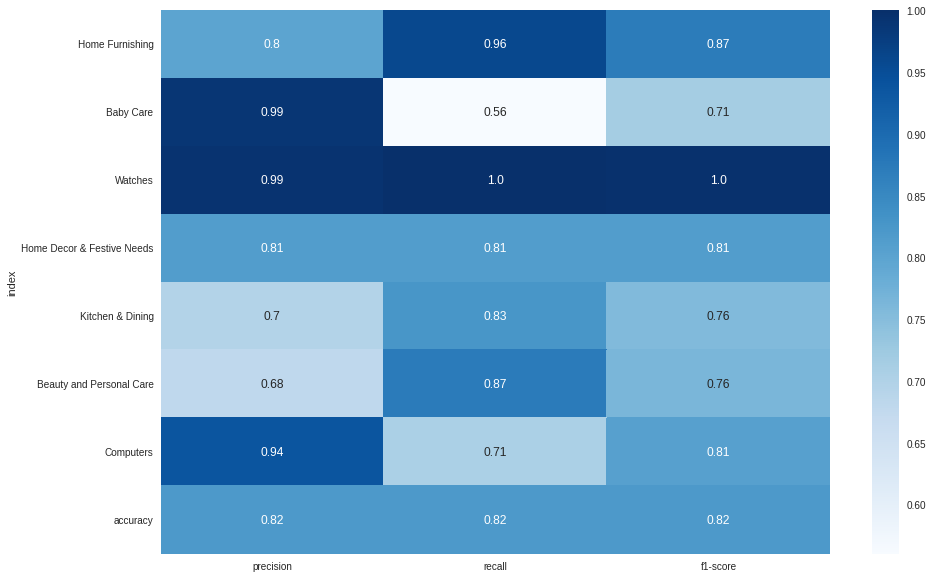

In [ ]:
vis_class_rapport(w2v_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(w2v_result.target_int, w2v_result.kmeans_w2v)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.64


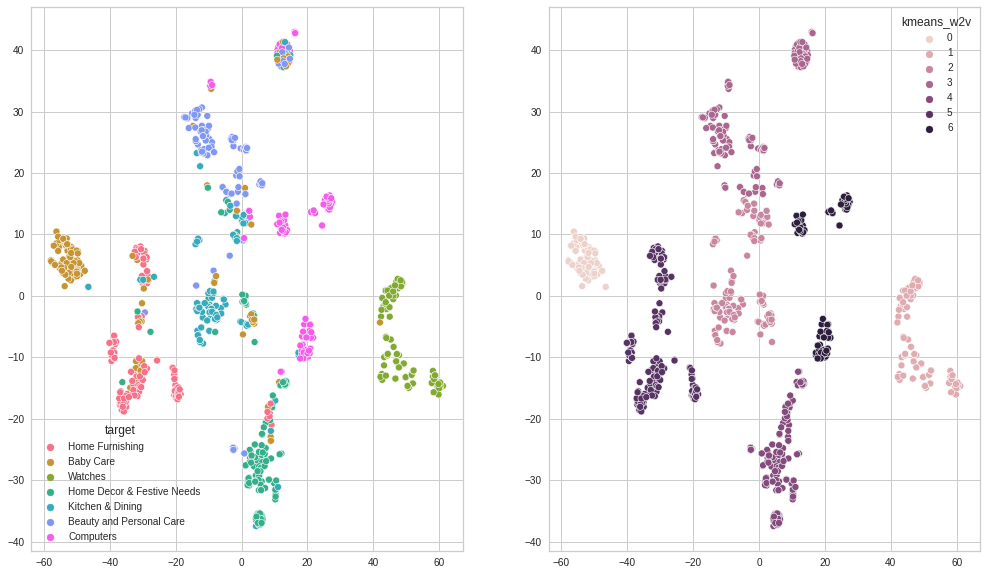

In [ ]:
vis_true_pred(X_embedded_w2v, w2v_result, 'target', 'kmeans_w2v')

On obtient un très bon ARI score et une accuracy de 0.82 avec le nom du produit. Cette différence avec le 1er notebook peut venir de la taille de notre corpus et donc utiliser seulement le nom du produit entraine une meilleure performance.

## <a name = "SE">Sentence embedding</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "SE1">BERT</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(preprocess_url)

text_bert = df['product_name_new'].apply(lambda x: text_preprocessing(x))
text_bert[:5]

0    elegance polyester multicolor abstract eyelet ...
1                           sathiyas cotton bath towel
2                  eurospa cotton terry face towel set
3    santosh royal fashion cotton printed king size...
4    jaipur print cotton floral king sized double b...
Name: product_name_new, dtype: object

In [ ]:
text_preprocessed = bert_preprocess_model(text_bert)

bert_model = hub.KerasLayer(encoder_url)
bert_result = bert_model(text_preprocessed)
bert_vecteur = bert_result['pooled_output']

mat_vec_bert = np.array(bert_vecteur)
df_vec_bert = pd.DataFrame(mat_vec_bert, columns = ['v' + str(i+1) for i in range(mat_vec_bert.shape[1])])
df_vec_bert.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v759,v760,v761,v762,v763,v764,v765,v766,v767,v768
0,-0.886045,-0.434379,-0.865961,0.861259,0.729597,-0.146440,0.892003,0.303128,-0.645631,-0.999983,...,0.551815,-0.541882,0.951018,0.877527,-0.389384,0.292181,0.657782,-0.628303,-0.693767,0.890407
1,-0.862671,-0.482788,-0.902036,0.787448,0.667246,-0.163952,0.878527,0.396449,-0.712617,-0.999983,...,0.429492,-0.447686,0.936255,0.846104,-0.358845,0.260815,0.562941,-0.766142,-0.687027,0.805722
2,-0.760829,-0.257627,-0.192784,0.585373,0.231709,-0.085180,0.852164,0.212606,0.115875,-0.999827,...,0.437708,0.235871,0.445355,0.809648,0.017745,0.488011,0.519177,-0.129697,-0.595541,0.884166
3,-0.849145,-0.438783,-0.789692,0.818392,0.757892,-0.115985,0.874932,0.292855,-0.473149,-0.999980,...,0.378539,-0.276249,0.922171,0.888567,0.007395,0.530643,0.482410,-0.583839,-0.660117,0.880844
4,-0.854125,-0.407627,-0.856424,0.857311,0.766702,-0.189682,0.892437,0.291216,-0.626125,-0.999985,...,0.492892,-0.349501,0.933988,0.863253,-0.153117,0.392808,0.597873,-0.697966,-0.713182,0.880287


In [ ]:
X_embedded_bert = reduc_tsne(df_vec_bert)
bert_result = kmeans_result(X_embedded_bert, df, 'kmeans_bert')

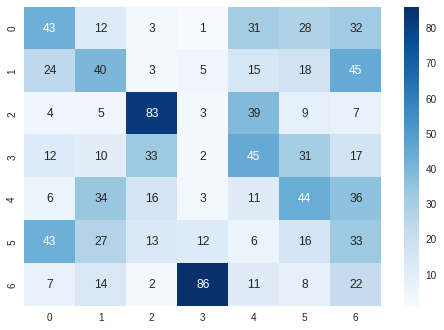

In [ ]:
cm = confusion_matrix(bert_result.target_int, bert_result.kmeans_bert)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

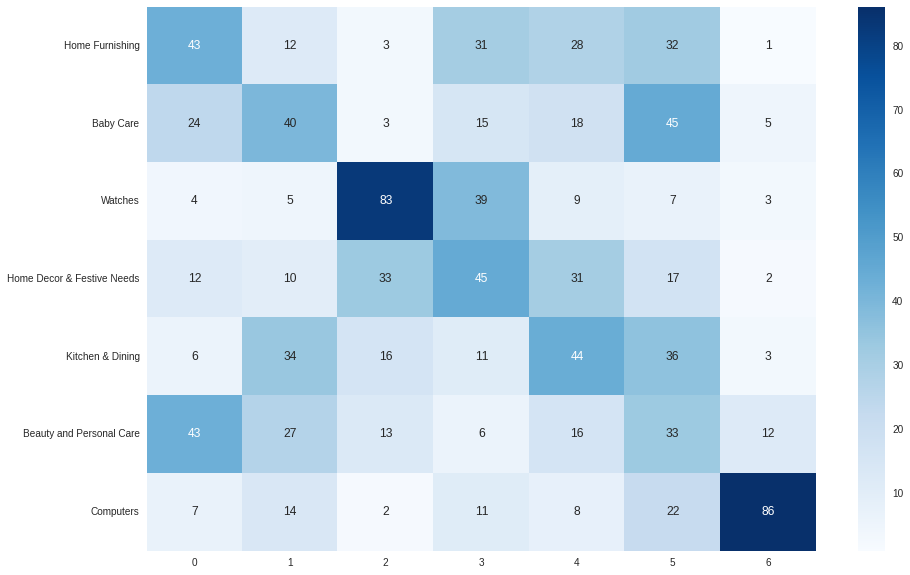

In [ ]:
labels_trans = transform_conf_mat(bert_result.kmeans_bert,[0, 1, 2, 6, 3, 4, 5])
vis_conf_mat(labels_trans, bert_result, 'target_int')

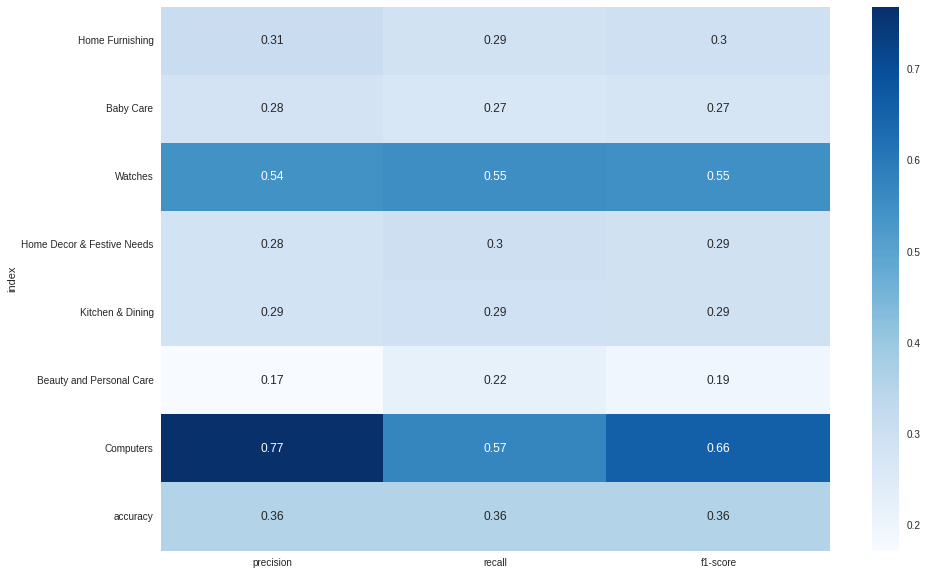

In [ ]:
vis_class_rapport(bert_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(bert_result.target_int, bert_result.kmeans_bert)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.12


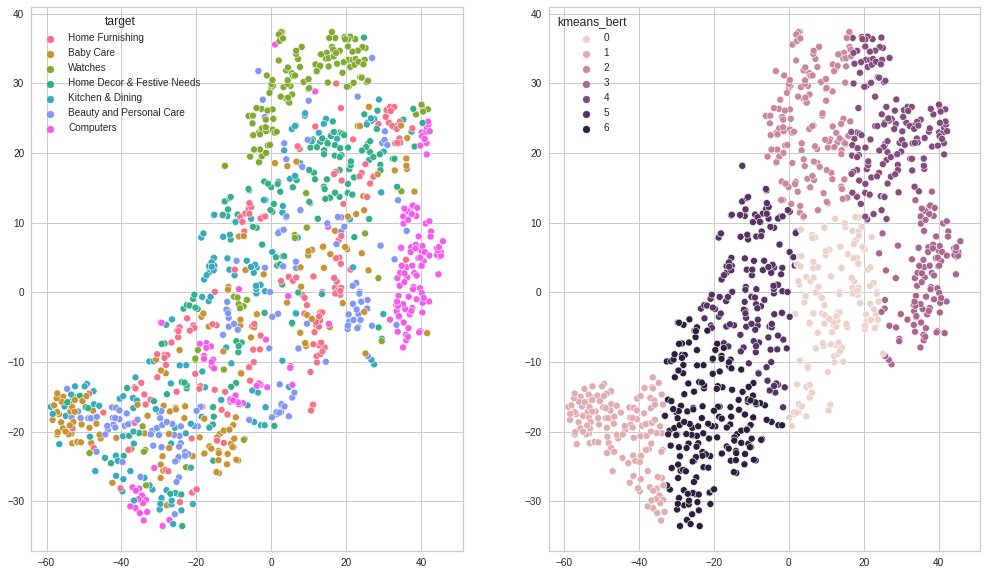

In [ ]:
vis_true_pred(X_embedded_bert, bert_result, 'target', 'kmeans_bert')

### <a name = "SE1">USE</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_vec = embed(text_bert)
use_vec

<tf.Tensor: shape=(1050, 512), dtype=float32, numpy=
array([[ 0.05646455, -0.0166991 , -0.0370861 , ..., -0.01305964,
         0.04983915,  0.06384217],
       [ 0.00599405,  0.05433534, -0.00869234, ..., -0.00258876,
         0.06814882,  0.02568774],
       [ 0.02507095,  0.00259155, -0.0042601 , ..., -0.00587555,
         0.05306112, -0.00711143],
       ...,
       [ 0.06634289,  0.05062016,  0.01086109, ..., -0.04865094,
         0.06148614, -0.06246344],
       [ 0.05647468,  0.03322315,  0.0616175 , ..., -0.02976299,
        -0.01674185, -0.0215883 ],
       [ 0.01983392,  0.06305395,  0.07477678, ..., -0.006964  ,
        -0.02285352, -0.01964251]], dtype=float32)>

In [ ]:
mat_vec_use = np.array(use_vec)
df_vec_use = pd.DataFrame(mat_vec_use, columns = ['v' + str(i+1) for i in range(mat_vec_use.shape[1])])
df_vec_use.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v503,v504,v505,v506,v507,v508,v509,v510,v511,v512
0,0.056465,-0.016699,-0.037086,0.043791,0.002945,0.067963,-0.016188,0.046416,0.033914,0.019882,...,-0.057716,-0.015940,-0.017477,0.069993,0.053311,-0.006422,0.019230,-0.013060,0.049839,0.063842
1,0.005994,0.054335,-0.008692,0.028411,0.077500,0.083581,0.034467,-0.015866,-0.013572,0.062917,...,0.064480,-0.043876,-0.055092,-0.053607,-0.018392,-0.045410,-0.046664,-0.002589,0.068149,0.025688
2,0.025071,0.002592,-0.004260,0.015883,0.065168,0.011295,0.043309,0.011210,0.024398,0.050517,...,0.062329,0.024114,-0.049997,-0.030061,0.064751,-0.010890,-0.020399,-0.005876,0.053061,-0.007111
3,-0.056970,-0.036166,0.026730,0.055229,0.066253,-0.000522,-0.050997,-0.042714,0.026418,-0.004167,...,0.030921,0.029273,0.024475,0.059347,0.064181,-0.074451,-0.013979,-0.002841,-0.041746,-0.036411
4,-0.022603,-0.025289,0.010708,-0.007875,0.067033,-0.003882,0.005227,-0.019191,0.055142,0.002674,...,-0.000996,0.009421,-0.010557,0.048562,-0.023992,-0.066663,-0.004540,-0.000940,-0.049134,-0.014796


In [ ]:
X_embedded_use = reduc_tsne(df_vec_use)
use_result = kmeans_result(X_embedded_use, df, 'kmeans_use')

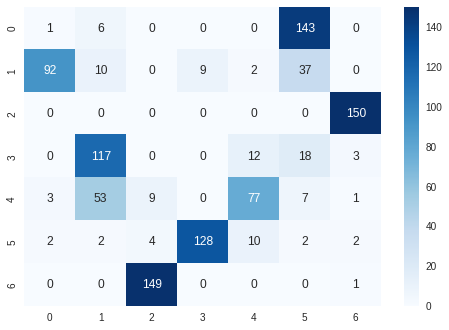

In [ ]:
cm = confusion_matrix(use_result.target_int, use_result.kmeans_use)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

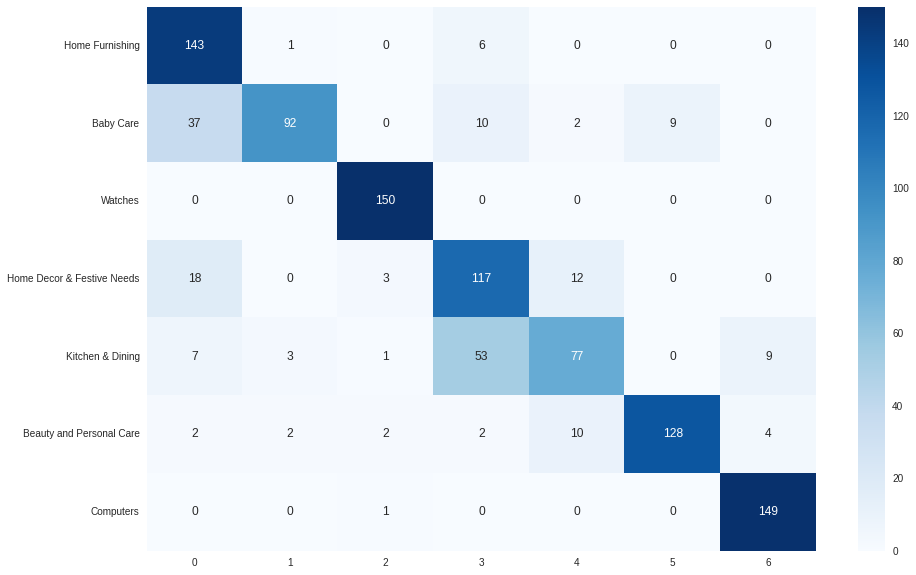

In [ ]:
labels_trans = transform_conf_mat(use_result.kmeans_use,[1, 3, 6, 5, 4, 0, 2])
vis_conf_mat(labels_trans, use_result, 'target_int')

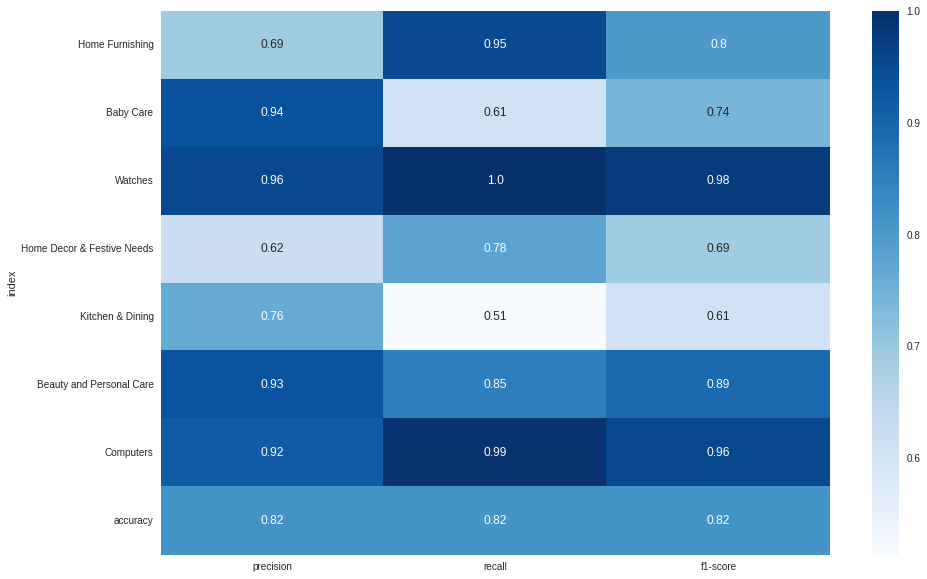

In [ ]:
vis_class_rapport(use_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(use_result.target_int, use_result.kmeans_use)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.65


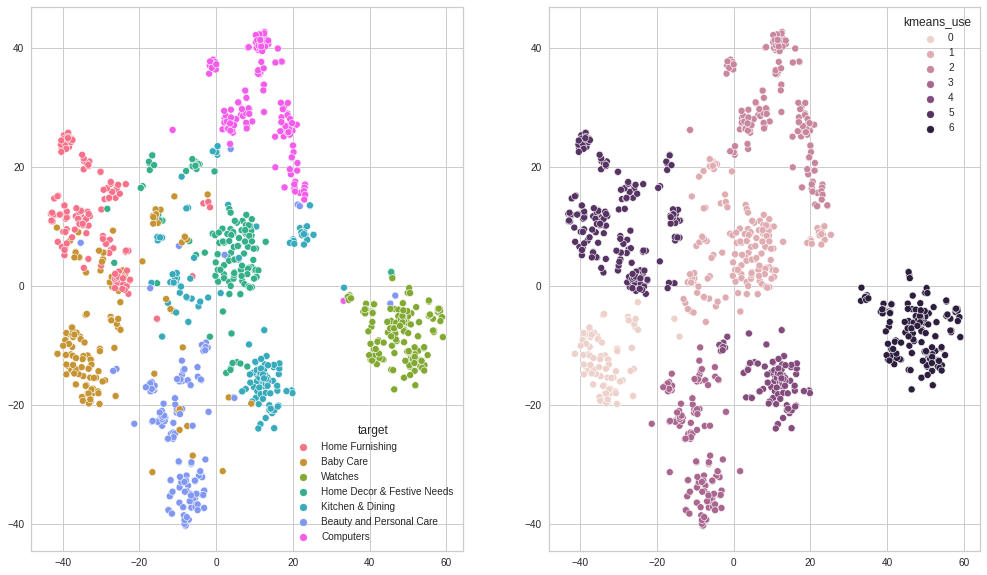

In [ ]:
vis_true_pred(X_embedded_use, use_result, 'target', 'kmeans_use')

On obtient notre meilleur résultat avec USE avec seulement le nom des produits. Avec un ARI de 0.65 et une accuracy de 0.82. Cette différence avec le notebook précedent peut venir du fait que le nom des produits seul soit plus facile a traiter que les descriptions complètes qui peuvent être plus longues et donc plus complexes.

### <a name = "Conclusion">Conclusion</a> <a href ="#sommaire"> Retour au sommaire</a>

Avec les différents résultats obtenus on peut conclure qu'on devrait avoir un moteur de classification assez performant. Cependant il faudra re-tester toutes ces approches avec des algorithmes suppervisés et vérifier les performances des modèles sur des données non vues, afin d'avoir une bonne estimation des performances des différentes méthodes et choisir la plus adéquation pour ce problème. De plus pour la réduction de dimension, il vaudrait mieux utiliser UMAP plutôt que TSNE qui fournit une méthode transform alors que TSNE ne la fournit pas.